In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # yellow-green
    '#17becf'   # cyan
]


In [32]:
import pandas as pd

# Input data
runtime_data = {
    "store_conf": [
        "TMPFS 2n", "TMPFS 4n",
        "BeeGFS 2n", "BeeGFS 4n",
    ],
    "openmm+aggregate": [114, 143, 110, 113],
    "openmm+train": [205, 231, 212, 214],
    "openmm+inference": [126, 169, 122, 134]
}

# Create DataFrame
df = pd.DataFrame(runtime_data)

# Construct result dictionary
runtime_rank_dict = {}
for col in df.columns[1:]:  # exclude 'store_conf'
    sorted_df = df[['store_conf', col]].sort_values(by=col)
    rankings = {row['store_conf']: rank+1 for rank, row in enumerate(sorted_df.to_dict('records'))}
    runtime_rank_dict[col] = [
        {
            "store_conf": row['store_conf'],
            "runtime": row[col],
            "rank": rankings[row['store_conf']]
        }
        for _, row in df.iterrows()
    ]

# Display runtime_rank_dict dictionary
import json
print(json.dumps(runtime_rank_dict, indent=2))


{
  "openmm+aggregate": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 114,
      "rank": 3
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 143,
      "rank": 4
    },
    {
      "store_conf": "BeeGFS 2n",
      "runtime": 110,
      "rank": 1
    },
    {
      "store_conf": "BeeGFS 4n",
      "runtime": 113,
      "rank": 2
    }
  ],
  "openmm+train": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 205,
      "rank": 1
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 231,
      "rank": 4
    },
    {
      "store_conf": "BeeGFS 2n",
      "runtime": 212,
      "rank": 2
    },
    {
      "store_conf": "BeeGFS 4n",
      "runtime": 214,
      "rank": 3
    }
  ],
  "openmm+inference": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 126,
      "rank": 2
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 169,
      "rank": 4
    },
    {
      "store_conf": "BeeGFS 2n",
      "runtime": 122,
      "rank": 1
    },
    

In [33]:
import pandas as pd

# Input data
spm_data = {
    "store_conf": [
        "TMPFS 2n", "TMPFS 4n",
        "BeeGFS 2n", "BeeGFS 4n",
    ],
    "openmm+aggregate": [91.21511151, 94.65189594, 38.01161497, 40.94923739],
    "openmm+train": [37.05636968, 38.45259675, 15.44231518, 16.63579107],
    "openmm+inference": [101.6395023, 105.4690548, 42.35571334, 45.62905787]
}
df = pd.DataFrame(spm_data)

# Helper to extract number of nodes
def extract_nodes(conf):
    return int(conf.split()[1][:-1])

# Construct dictionary
spm_rank_dict = {}
for column in df.columns[1:]:
    # Rank using value ascending, then node count descending
    sorted_df = df.sort_values(
        by=[column, "store_conf"],
        key=lambda col: (
            col if col.name != "store_conf" else col.map(lambda x: -extract_nodes(x))
        ),
        ascending=[True, True]
    ).reset_index()

    # Build a lookup table for ranks
    rank_lookup = {
        df.loc[i, "store_conf"]: rank+1 for rank, i in enumerate(sorted_df["index"])
    }

    # Store spm_rank_dict per column
    spm_rank_dict[column] = [
        {
            "store_conf": row["store_conf"],
            "runtime": row[column],
            "rank": rank_lookup[row["store_conf"]]
        }
        for _, row in df.iterrows()
    ]

# Optional: print or export
import json
print(json.dumps(spm_rank_dict, indent=2))



{
  "openmm+aggregate": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 91.21511151,
      "rank": 3
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 94.65189594,
      "rank": 4
    },
    {
      "store_conf": "BeeGFS 2n",
      "runtime": 38.01161497,
      "rank": 1
    },
    {
      "store_conf": "BeeGFS 4n",
      "runtime": 40.94923739,
      "rank": 2
    }
  ],
  "openmm+train": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 37.05636968,
      "rank": 3
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 38.45259675,
      "rank": 4
    },
    {
      "store_conf": "BeeGFS 2n",
      "runtime": 15.44231518,
      "rank": 1
    },
    {
      "store_conf": "BeeGFS 4n",
      "runtime": 16.63579107,
      "rank": 2
    }
  ],
  "openmm+inference": [
    {
      "store_conf": "TMPFS 2n",
      "runtime": 101.6395023,
      "rank": 3
    },
    {
      "store_conf": "TMPFS 4n",
      "runtime": 105.4690548,
      "rank": 4
    },
    {
  

In [34]:
import pandas as pd

def compute_rank_error(runtime_rank_dict, spm_rank_dict):
    stages = list(runtime_rank_dict.keys())
    num_ranks = len(runtime_rank_dict[stages[0]])  # Typically 9
    rank_error_table = []

    for rank_idx in range(num_ranks):  # R1 to R9
        rank_row = []
        for stage in stages:
            # Find store_conf predicted by SPM at current rank
            spm_entry = next((entry for entry in spm_rank_dict[stage] if entry["rank"] == rank_idx+1), None)
            if not spm_entry:
                rank_row.append(None)
                continue
            predicted_conf = spm_entry["store_conf"]

            # Find actual rank of the predicted store_conf
            actual_entry = next((entry for entry in runtime_rank_dict[stage] if entry["store_conf"] == predicted_conf), None)
            if not actual_entry:
                rank_row.append(None)
                continue
            actual_rank = actual_entry["rank"]

            # Calculate absolute difference
            rank_error = abs((rank_idx+1) - actual_rank)
            rank_row.append(rank_error)
        rank_error_table.append(rank_row)

    # Format as DataFrame
    rank_labels = [f"R{i+1}" for i in range(num_ranks)]
    df_rank_error = pd.DataFrame(rank_error_table, columns=stages, index=rank_labels)
    return df_rank_error

# Example usage:
rank_error_table = compute_rank_error(runtime_rank_dict, spm_rank_dict)
print(rank_error_table)


    openmm+aggregate  openmm+train  openmm+inference
R1                 0             1                 0
R2                 0             1                 1
R3                 0             2                 1
R4                 0             0                 0


In [35]:
import pandas as pd

def compute_local_rank_deviation(runtime_rank_dict, spm_rank_dict):
    stages = list(runtime_rank_dict.keys())
    num_ranks = len(runtime_rank_dict[stages[0]])  # Typically 9 ranks
    penalty_table = []

    for rank_idx in range(num_ranks):  # R1 to R9
        rank_row = []
        for stage in stages:
            # Get the actual store_conf at this rank
            actual_entry = next((entry for entry in runtime_rank_dict[stage] if entry["rank"] == rank_idx+1), None)
            print(f"{stage}: R[{rank_idx}] actual_entry:{actual_entry}")
            if not actual_entry:
                rank_row.append(None)
                continue
            actual_conf = actual_entry["store_conf"]
            actual_runtime = actual_entry["runtime"]

            # Get the SPM-predicted rank for that same store_conf
            spm_entry = next((entry for entry in spm_rank_dict[stage] if entry["rank"] == rank_idx+1), None)
            
            if not spm_entry:
                rank_row.append(None)
                continue
            spm_conf = spm_entry["store_conf"]
            spm_actual_entry = next((entry for entry in runtime_rank_dict[stage] if entry["store_conf"] == spm_conf), None)
            spm_runtime = spm_actual_entry["runtime"]
            print(f"{stage}: R[{rank_idx}] spm_runtime:{spm_runtime} spm_entry:{spm_entry}")

            # Compute penalty: can be negative or positive
            penalty_percent = 100 * (spm_runtime - actual_runtime) / actual_runtime
            rank_row.append(penalty_percent)
        penalty_table.append(rank_row)

    # Format as DataFrame
    rank_labels = [f"R{i+1}" for i in range(num_ranks)]
    df_penalty = pd.DataFrame(penalty_table, columns=stages, index=rank_labels)
    return df_penalty

# Example usage:
local_deviation_table = compute_local_rank_deviation(runtime_rank_dict, spm_rank_dict)
print(local_deviation_table)


openmm+aggregate: R[0] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 110, 'rank': 1}
openmm+aggregate: R[0] spm_runtime:110 spm_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 38.01161497, 'rank': 1}
openmm+train: R[0] actual_entry:{'store_conf': 'TMPFS 2n', 'runtime': 205, 'rank': 1}
openmm+train: R[0] spm_runtime:212 spm_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 15.44231518, 'rank': 1}
openmm+inference: R[0] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 122, 'rank': 1}
openmm+inference: R[0] spm_runtime:122 spm_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 42.35571334, 'rank': 1}
openmm+aggregate: R[1] actual_entry:{'store_conf': 'BeeGFS 4n', 'runtime': 113, 'rank': 2}
openmm+aggregate: R[1] spm_runtime:113 spm_entry:{'store_conf': 'BeeGFS 4n', 'runtime': 40.94923739, 'rank': 2}
openmm+train: R[1] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 212, 'rank': 2}
openmm+train: R[1] spm_runtime:214 spm_entry:{'store_conf': 'BeeGFS 4n', 'runtime': 16.63579107, 'rank': 2}
op

In [36]:
import pandas as pd

def compute_global_rank_deviation(runtime_rank_dict, spm_rank_dict):
    stages = list(runtime_rank_dict.keys())
    num_ranks = len(runtime_rank_dict[stages[0]])  # Typically 9 ranks
    penalty_table = []

    for rank_idx in range(num_ranks):  # R1 to R9
        rank_row = []
        for stage in stages:
            # Get the actual store_conf at this rank
            actual_entry = next((entry for entry in runtime_rank_dict[stage] if entry["rank"] == rank_idx+1), None)
            print(f"{stage}: R[{rank_idx}] actual_entry:{actual_entry}")
            if not actual_entry:
                rank_row.append(None)
                continue
            actual_conf = actual_entry["store_conf"]
            actual_runtime = actual_entry["runtime"]

            # Get the SPM-predicted rank actual runtime of workflow with the same rank storages
            rank_runtime = 0
            for st in stages:
                entry = next((entry for entry in runtime_rank_dict[st] if entry["rank"] == rank_idx+1), None)
                rank_runtime += entry["runtime"]
            
            # Get the SPM-predicted rank actual runtime for that same store_conf
            spm_entry = next((entry for entry in spm_rank_dict[stage] if entry["rank"] == rank_idx+1), None)
            
            if not spm_entry:
                rank_row.append(None)
                continue
            spm_conf = spm_entry["store_conf"]
            spm_actual_entry = next((entry for entry in runtime_rank_dict[stage] if entry["store_conf"] == spm_conf), None)
            spm_runtime = spm_actual_entry["runtime"]
            print(f"{stage}: R[{rank_idx}] spm_runtime[{spm_conf}]:{spm_runtime} , rank_runtime:{rank_runtime}")

            # Compute penalty: can be negative or positive
            penalty_percent = 100 * (spm_runtime - actual_runtime) / rank_runtime
            rank_row.append(penalty_percent)
        penalty_table.append(rank_row)

    # Format as DataFrame
    rank_labels = [f"R{i+1}" for i in range(num_ranks)]
    df_penalty = pd.DataFrame(penalty_table, columns=stages, index=rank_labels)
    return df_penalty

# Example usage:
global_deviation_table = compute_global_rank_deviation(runtime_rank_dict, spm_rank_dict)
print(global_deviation_table)


openmm+aggregate: R[0] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 110, 'rank': 1}
openmm+aggregate: R[0] spm_runtime[BeeGFS 2n]:110 , rank_runtime:437
openmm+train: R[0] actual_entry:{'store_conf': 'TMPFS 2n', 'runtime': 205, 'rank': 1}
openmm+train: R[0] spm_runtime[BeeGFS 2n]:212 , rank_runtime:437
openmm+inference: R[0] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 122, 'rank': 1}
openmm+inference: R[0] spm_runtime[BeeGFS 2n]:122 , rank_runtime:437
openmm+aggregate: R[1] actual_entry:{'store_conf': 'BeeGFS 4n', 'runtime': 113, 'rank': 2}
openmm+aggregate: R[1] spm_runtime[BeeGFS 4n]:113 , rank_runtime:451
openmm+train: R[1] actual_entry:{'store_conf': 'BeeGFS 2n', 'runtime': 212, 'rank': 2}
openmm+train: R[1] spm_runtime[BeeGFS 4n]:214 , rank_runtime:451
openmm+inference: R[1] actual_entry:{'store_conf': 'TMPFS 2n', 'runtime': 126, 'rank': 2}
openmm+inference: R[1] spm_runtime[BeeGFS 4n]:134 , rank_runtime:451
openmm+aggregate: R[2] actual_entry:{'store_conf': 'TMPFS 

R1: [0, 1, 0]
R2: [0, 1, 1]
R3: [0, 2, 1]
R4: [0, 0, 0]


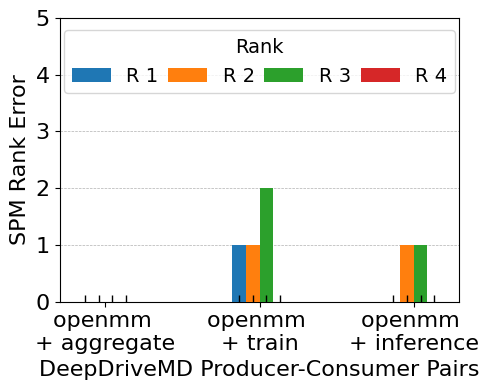

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Labels (workflows) and Ranks
labels = ['openmm \n+ aggregate', 'openmm \n+ train', 'openmm \n+ inference']
ranks = ['R 1', 'R 2', 'R 3', 'R 4']

# Convert DataFrame to list of lists (row-wise values only)
rank_error = rank_error_table.values.tolist()

# Optional: Display the result
for i, row in enumerate(rank_error, start=1):
    print(f"R{i}: {row}")


# Bar plot config
x = np.arange(len(labels))
bar_width = 0.09

plt.figure(figsize=(5, 4))
for i in range(len(ranks)):
    plt.bar(x+i * bar_width, rank_error[i], width=bar_width, color=colors[i], label=ranks[i], zorder=3)

# Add tick for 0 bars
for i in range(len(ranks)):
    for j, val in enumerate(rank_error[i]):
        xpos = x[j]+i * bar_width
        plt.plot(xpos, 0, marker='|', color='black', markersize=10, zorder=4)

# Axis and legend
plt.xticks(x+(len(ranks) - 1) * bar_width / 2, labels, fontsize=16)
plt.yticks(np.arange(0, 10, 1), fontsize=16)
plt.ylim(0, len(ranks)+1)
plt.ylabel('SPM Rank Error', fontsize=16)
plt.xlabel('DeepDriveMD Producer-Consumer Pairs', fontsize=16)
# plt.title('SPM Rank Error', fontsize=18)
plt.grid(axis='y', linestyle='--', linewidth=0.5, zorder=0)

# Legend on top
plt.legend(title='Rank', title_fontsize=14, fontsize=14, ncol=9, loc='lower center',
           bbox_to_anchor=(0.5, 0.7), columnspacing=0.5)

plt.tight_layout()
plt.savefig("ddmd_spm_rank_error.pdf", format='pdf', bbox_inches='tight')
plt.show()


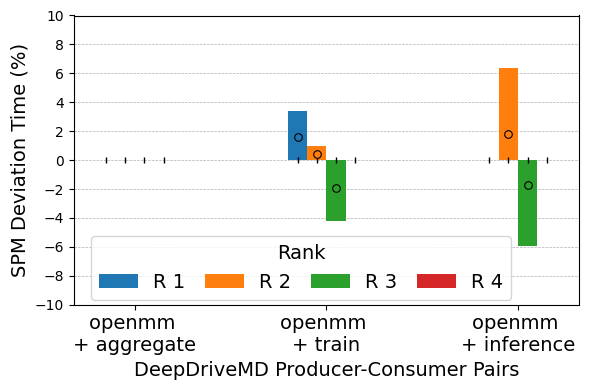

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Labels (workflows) and Ranks
labels = ['openmm \n+ aggregate', 'openmm \n+ train', 'openmm \n+ inference']
ranks = ['R 1', 'R 2', 'R 3', 'R 4']

# Bar and dot plot data
local_deviation = local_deviation_table.values.tolist()
global_deviation = global_deviation_table.values.tolist()

x = np.arange(len(labels))
bar_width = 0.1
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot bars
for i in range(len(ranks)):
    for j, val in enumerate(local_deviation[i]):
        xpos = x[j]+i * bar_width
        label = ranks[i] if j == 0 else None  # Only label once per rank
        bar = ax1.bar(xpos, val, width=bar_width, color=colors[i], label=label, zorder=3)

        # Add text if bar > 100
        if val > 50:
            ax1.text(
                xpos, 40, f'{val:.1f}',
                ha='center', va='bottom', fontsize=7, rotation=90, color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='square,pad=0.8', alpha=0.6)
            )
        if val < -50:
            ax1.text(
                xpos, -40, f'{val:.1f}',
                ha='center', va='bottom', fontsize=7, rotation=90, color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='square,pad=0.8', alpha=0.6)
            )

# Tick marker for 0 bars
for i in range(len(ranks)):
    for j, val in enumerate(local_deviation[i]):
        xpos = x[j]+i * bar_width
        ax1.plot(xpos, 0, marker='|', color='black', markersize=5, zorder=4)

# Plot dots with annotations
for i in range(len(ranks)):
    for j, val in enumerate(global_deviation[i]):
        xpos = x[j]+i * bar_width
        if val != 0:
            ax1.scatter(
                xpos, val,
                color=colors[i],
                marker='o',
                s=30,
                edgecolors='black',
                linewidths=0.8,
                zorder=6
            )

            # Add text below dot if > 50
            if val > 50:
                ax1.text(
                    xpos, 20, f'{val:.1f}',
                    ha='center', va='top', fontsize=7, rotation=90,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8', alpha=0.8)
                )
            if val < -50:
                ax1.text(
                    xpos, -20, f'{val:.1f}',
                    ha='center', va='top', fontsize=7, rotation=90,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8', alpha=0.8)
                )

# Axes setup
centered_x = x+((len(ranks) - 1) * bar_width) / 2
ax1.set_xticks(centered_x)
ax1.set_xticklabels(labels, fontsize=14)
ax1.set_yticks(np.arange(-100, 101, 2))
ax1.set_ylim(-10, 10)
ax1.set_ylabel('SPM Deviation Time (%)', fontsize=14)
ax1.set_xlabel('DeepDriveMD Producer-Consumer Pairs', fontsize=14)
ax1.grid(axis='y', linestyle='--', linewidth=0.5, zorder=0)

# Legend
ax1.legend(title='Rank', title_fontsize=14, fontsize=14, ncol=6, loc='upper center', 
           bbox_to_anchor=(0.45, 0.27), columnspacing=1)

plt.tight_layout()
plt.savefig("ddmd_spm_time_deviation.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Error rate over 10% global margin of error: 0/12
# Error rate over 10% local margin of error: 0/12
